# Applied Machine Learning: Homework Exercise 10-1

## Goal

Implement Greedy Ensemble Selection from scratch. Learn how to do stacking using `scikit-learn`.


### Prerequisites

You will use the `credit-g` dataset from OpenML.  

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml

rng = np.random.default_rng(2409)
X, y = fetch_openml(name="credit-g", version=1, as_frame=True, return_X_y=True)

categorical_features = X.select_dtypes(include=["object", "category"]).columns
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
# This time, we need to encode y, otherwise the cross_val_score will throw an error later.
y = y.map({"good": 1, "bad": 0}).astype(int)

## 1 Implement Greedy Ensemble Selection

In previous exercises, we explored how to perform weighted model averaging and how to optimize weights numerically. We now want to implement a widely used method for optimizing ensemble weights: **Greedy Ensemble Selection (GES)**.

First, read the [original paper](https://www.cs.cornell.edu/~caruana/ctp/ct.papers/caruana.icml04.icdm06long.pdf)  
Also review the lecture slides and in-class material covering GES.

In the in-class exercises, we built ensembles of a decision tree, a k-NN classifier, and logistic regression. Previously, we used a numerical optimizer to determine the best weights for model averaging by defining an objective function that directly optimizes performance (e.g., AUC).

In this exercise, instead of optimizing the weights using CMA-ES, we will implement GES from scratch without relying on any existing optimizer framework. After implementing GES, you will evaluate its performance and compare it to the CMA-ES optimized ensemble.

We first do the train-test split and maintain a seperate test set with `test_size=0.25` for the final evaluation.

### Task

- You will use the models:  
  - `DecisionTreeClassifier` (with max depth 10)  
  - `KNeighborsClassifier` (wrapped in a `Pipeline` with `StandardScaler`)  
  - `LogisticRegression` (also wrapped in a `Pipeline` with `StandardScaler`)  
  - A baseline `DummyClassifier` for reference

- Perform **10-fold cross-validation** on the training data. For each model, collect the predicted probabilities and true labels for each fold.

- Implement two methods of ensemble weight optimization:
  1. **Numerical optimization** using CMA-ES (`cma` library)
  2. **Greedy Ensemble Selection (GES)**: iteratively build an ensemble by greedily selecting models to maximize mean CV AUC.

- Finally, use the learned weights from both approaches to evaluate performance on the **outer test set split**. Compare:

  - Each base model  
  - Uniform-weighted ensemble  
  - CMA-ES-weighted ensemble  
  - GES-weighted ensemble  
  - Featureless classifier (majority class prediction)

<details><summary>Hint 1:</summary>
In GES, at each iteration, select the model that, when added to the current ensemble, improves the average AUC on the cross-validation folds the most.
</details>

<details><summary>Hint 2:</summary>
Use the `VotingClassifier` from `sklearn.ensemble` with `voting='soft'` to implement ensemble predictions. You can pass a custom list of weights using the `weights` parameter.
</details>

In [2]:
#===SOLUTION===

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.ensemble import VotingClassifier
import cma


X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=2409
)

dt = DecisionTreeClassifier(max_depth=10, random_state=2409)

knn = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=20))
])

log_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=2409))
])

featureless = DummyClassifier(strategy="most_frequent", random_state=2409)

models = [("dt", dt), ("knn", knn), ("log_reg", log_reg)]
n_models = len(models)

# Set up 10-fold cross validation on the training set
k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=2409)

# For each model, store predictions for each fold in a list.
# Each prediction dict will contain:
#    "row_ids": indices of the validation set,
#    "truth": true labels,
#    "prob": predicted probabilities (2 columns: prob for class 0 and 1)
model_preds = {name: [] for name, _ in models}

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    for name, model in models:
        model_clone = clone(model)
        model_clone.fit(X_tr, y_tr)
        prob = model_clone.predict_proba(X_val)
        model_preds[name].append({
            "row_ids": val_idx, 
            "truth": y_val.to_numpy(), 
            "prob": prob
        })

learner_preds = [model_preds["dt"], model_preds["knn"], model_preds["log_reg"]]

# CMA-ES Optimization of Ensemble Weights
def objective_cma(weights):
    weights = np.array(weights)
    # Normalize so weights sum to 1
    weights = weights / np.sum(weights)
    
    # Calculate AUC as before
    fold_aucs = []
    for fold in range(k):
        weighted_prob = np.zeros_like(learner_preds[0][fold]["prob"])
        for i in range(n_models):
            weighted_prob += weights[i] * learner_preds[i][fold]["prob"]
        auc = roc_auc_score(learner_preds[0][fold]["truth"], weighted_prob[:, 1])
        fold_aucs.append(auc)
    mean_auc = np.mean(fold_aucs)
    
    # Add regularization term - penalize deviation from uniform weights
    uniform_weights = np.ones(len(weights)) / len(weights)
    regularization_term = 0.2 * np.sum((weights - uniform_weights)**2)
    
    # Return negative (AUC - regularization) since CMA-ES minimizes
    return -mean_auc + regularization_term

# Initial guess: equal weights
initial_weights = [1 / n_models] * n_models
sigma0 = 0.1
opts = {'bounds': [0, 1], 'seed': 2409, 'maxfevals': 100}
es = cma.CMAEvolutionStrategy(initial_weights, sigma0, opts)
es.optimize(objective_cma)
cma_result = es.result
cma_weights = cma_result.xbest
cma_weights = cma_weights / np.sum(cma_weights)

# Greedy Ensemble Selection (GES)
def get_ges_weights(selected, n_learners):
    """
    Given a list of selected learner indices (e.g. [0, 2, 0, 1, ...]),
    compute the weight for each learner as the fraction of times it appears.
    """
    if len(selected) == 0:
        return np.zeros(n_learners)
    counts = np.zeros(n_learners)
    for idx in selected:
        counts[idx] += 1
    return counts / len(selected)

def ges(learner_preds, iterations=100, pos_class_index=1):
    """
    Greedy Ensemble Selection.
    At each iteration, try adding each learner (by its index) to the ensemble;
    select the candidate that maximizes the mean CV AUC.
    
    Returns a dict with:
      - best_iteration: iteration (1-indexed) with best performance,
      - performance_best: best mean AUC,
      - weights: final ensemble weights,
      - selected: list of learner indices added at each iteration,
      - performance: list of mean AUC per iteration.
    """
    n_learners = len(learner_preds)
    k = len(learner_preds[0])
    performance_history = []
    selected = []
    
    for iteration in range(iterations):
        candidate_performances = []
        # Try adding each candidate learner
        for candidate in range(n_learners):
            candidate_selected = selected + [candidate]
            weights = get_ges_weights(candidate_selected, n_learners)
            fold_aucs = []
            for fold in range(k):
                weighted_prob = np.zeros_like(learner_preds[0][fold]["prob"])
                for i in range(n_learners):
                    weighted_prob += weights[i] * learner_preds[i][fold]["prob"]
                auc = roc_auc_score(learner_preds[0][fold]["truth"], weighted_prob[:, pos_class_index])
                fold_aucs.append(auc)
            candidate_performances.append(np.mean(fold_aucs))
        best_candidate = int(np.argmax(candidate_performances))
        best_performance = candidate_performances[best_candidate]
        performance_history.append(best_performance)
        selected.append(best_candidate)
        print(f"GES Iteration: {iteration + 1}, "
              f"Candidate performances: {[f'{p:.3f}' for p in candidate_performances]}, "
              f"Selected candidate: {best_candidate}, AUC: {best_performance:.3f}")
    
    # Determine the iteration with the best performance
    best_iteration = np.argmax(performance_history)
    ges_weights = get_ges_weights(selected[:best_iteration + 1], n_learners)
    return {
        "best_iteration": best_iteration + 1,  # converting to 1-indexed for reporting
        "performance_best": performance_history[best_iteration],
        "weights": ges_weights,
        "selected": selected,
        "performance": performance_history
    }

ges_results = ges(learner_preds, iterations=150, pos_class_index=1)

print("\nCMA-ES optimized weights:")
for i, (name, _) in enumerate(models):
    print(f"\t{name}: {cma_weights[i]:.4f}")

print("\nGES optimized weights:")
for i, (name, _) in enumerate(models):
    print(f"\t{name}: {ges_results['weights'][i]:.4f}")

# Evaluate on the outer test set
def evaluate_single_model(X_train, y_train, X_test, y_test, model, pos_class_index=1):
    """
    Train a single model on the training set and evaluate on the test set.
    Return the AUC using the probability of the positive class.
    """
    model_clone = clone(model)
    model_clone.fit(X_train, y_train)
    prob = model_clone.predict_proba(X_test)
    return roc_auc_score(y_test, prob[:, pos_class_index])

# Evaluate all models and ensembles
results = {}

# Evaluate single models
for name, model in models:
    results[f"Single model: {name}"] = evaluate_single_model(X_train, y_train, X_test, y_test, model)

# Evaluate featureless classifier
featureless_clone = clone(featureless)
featureless_clone.fit(X_train, y_train)
featureless_prob = featureless_clone.predict_proba(X_test)
results["Single model: featureless"] = roc_auc_score(y_test, featureless_prob[:, 1])

# Create and evaluate VotingClassifier with uniform weights
uniform_voting = VotingClassifier(estimators=models, voting='soft')
uniform_voting.fit(X_train, y_train)
uniform_proba = uniform_voting.predict_proba(X_test)
results["Ensemble: Uniform weights"] = roc_auc_score(y_test, uniform_proba[:, 1])

# Create and evaluate VotingClassifier with CMA-ES weights
cma_voting = VotingClassifier(
    estimators=models, 
    voting='soft',
    weights=cma_weights
)
cma_voting.fit(X_train, y_train)
cma_proba = cma_voting.predict_proba(X_test)
results["Ensemble: CMA-ES weights"] = roc_auc_score(y_test, cma_proba[:, 1])

# Create and evaluate VotingClassifier with GES weights
ges_voting = VotingClassifier(
    estimators=models, 
    voting='soft',
    weights=ges_results["weights"]
)
ges_voting.fit(X_train, y_train)
ges_proba = ges_voting.predict_proba(X_test)
results["Ensemble: GES weights"] = roc_auc_score(y_test, ges_proba[:, 1])

print("\nModel Performance Comparison (AUC on test set):")
print("-" * 50)
print(f"{'Model':<30} | {'AUC':<10}")
print("-" * 50)
for model_name, auc in results.items():
    print(f"{model_name:<30} | {auc:.4f}")
print("-" * 50)

(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=2409, Wed Jun  4 20:05:36 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 -7.628545011958945e-01 1.0e+00 1.08e-01  1e-01  1e-01 0:00.0
    2     14 -7.627049314410175e-01 1.3e+00 1.11e-01  1e-01  1e-01 0:00.1
    3     21 -7.633552385055847e-01 1.2e+00 9.92e-02  9e-02  1e-01 0:00.2
   15    105 -7.642318672903751e-01 3.9e+00 2.81e-02  9e-03  2e-02 0:00.6
GES Iteration: 1, Candidate performances: ['0.650', '0.736', '0.767'], Selected candidate: 2, AUC: 0.767
GES Iteration: 2, Candidate performances: ['0.744', '0.768', '0.767'], Selected candidate: 1, AUC: 0.768
GES Iteration: 3, Candidate performances: ['0.752', '0.764', '0.771'], Selected candidate: 2, AUC: 0.771
GES Iteration: 4, Candidate performances: ['0.766', '0.768', '0.770'], Selected candidate: 2, AUC: 0.770
GES Iteration: 5, Candidate performances: ['0.769', '0.770', '0.769'], Selected candidate: 1, AUC: 0.770
GES Iteration: 6, C

## 2 Single- and Multilayer Stacking

### 2.1 Level 0

We now want to perform stacking. Use **six learners** at level 0:

- Decision Tree with `max_depth = 10` 
- k-NN with `n_neighbors = 7`
- Elastic Net logistic regression with `alpha = 0.5` and `s = 0.1` (this corresponds to `C = 10`)  
- Naive Bayes  
- XGBoost with 100 boosting rounds  
- Random Forest with 100 trees  

Apply **target (impact) encoding** to categorical features for the following learners:  
- Elastic Net  
- Naive Bayes  
- XGBoost  

Use **one-hot encoding** for:  
- Decision Tree  
- k-NN  
- Random Forest  

Use **standard scaling** to the numerical features for all learners.

You can use the `OnetHotEncoder` or `TargetEncoder` to encode categorical features.

At this point, do not use cross-validation at level 0. Instead, train each base learner on the full dataset.

Once the level 0 models are defined, stack them with a logistic regression as the level 1 model (meta-learner), which will be trained on the predicted probabilities of the base learners.

Finally, benchmark the stacked ensemble against each individual level 0 learner and the random forest using **5-fold cross-validation**, evaluating performance with the ROC AUC metric.

<details><summary>Hint 1:</summary>
Wrap each model in a `Pipeline` that includes the appropriate encoder (`ColumnTransformer` with `OneHotEncoder` or `TargetEncoder`).
</details>

<details><summary>Hint 2:</summary>
Creating an "in-sample" stacked ensemble in `sklearn` is not straightforward—especially when dealing with nested sampling. For a standard model, we typically define a cross-validation generator and pass it to `cross_val_score`, which handles the train-test loop internally. However, for an in-sample stacked ensemble, this approach doesn't work out of the box. Instead, we need to manually loop over the folds: in each fold, we first train and evaluate the base learners ourselves, then manually construct a `sklearn.ensemble.StackingClassifier` with `cv="prefit"` to avoid the default inner cross-validation at level 0.
</details>

<details><summary>Hint 3:</summary>
It is important to note that in the first cell, we applied one-hot encoding to X. However, in this exercise, different encoding strategies are applied to different ensemble candidates. Each ensemble candidate (a Pipeline) is equipped with its own preprocessor and performs feature preprocessing internally within the StackingClassifier. As a result, the input X passed to the StackingClassifier should remain unprocessed (i.e., raw). Therefore, we need to reload the original features using `X = fetch_openml('credit-g', ...).data`.
</details>

Categorical features: Index(['checking_status', 'credit_history', 'purpose', 'savings_status',
       'employment', 'personal_status', 'other_parties', 'property_magnitude',
       'other_payment_plans', 'housing', 'job', 'own_telephone',
       'foreign_worker'],
      dtype='object')
Numeric features: ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']

5-Fold CV ROC AUC Scores for Individual Models:
Decision Tree (OneHot): Mean AUC = 0.686, Scores = [0.68017857 0.6264881  0.67202381 0.71119048 0.74202381]
KNN (OneHot): Mean AUC = 0.718, Scores = [0.72416667 0.68708333 0.7064881  0.70940476 0.76130952]
Elastic Net (Impact): Mean AUC = 0.778, Scores = [0.78130952 0.7722619  0.80238095 0.73964286 0.79535714]
Naive Bayes (Impact): Mean AUC = 0.758, Scores = [0.77333333 0.76416667 0.7925     0.71059524 0.74869048]
XGBoost (Impact): Mean AUC = 0.780, Scores = [0.77452381 0.76845238 0.79035714 0.76690476 0.8002381 ]
Random

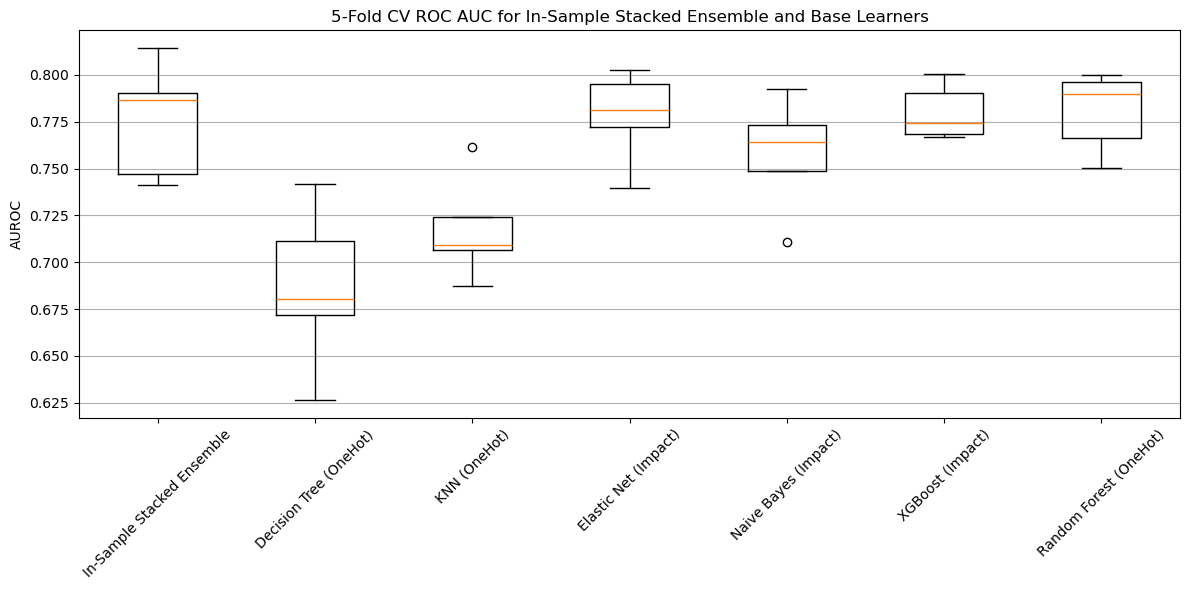

In [3]:
#===SOLUTION===

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from xgboost import XGBClassifier


# reload un-processed X
X = fetch_openml(name="credit-g", version=1, as_frame=True).data
numeric_features = [col for col in X.columns if col not in categorical_features]
print(f"Categorical features: {categorical_features}")
print(f"Numeric features: {numeric_features}")


# Create preprocessors
onehot_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

target_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', TargetEncoder(smooth=0.0001), categorical_features),
    ],
    remainder='drop'
)

# Decision Tree with OneHot Encoding
dt = Pipeline([
    ('preprocessor', onehot_preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=10, random_state=2409))
])

# k-NN with OneHot Encoding
knn = Pipeline([
    ('preprocessor', onehot_preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=7))
])

# Random Forest with OneHot Encoding
rf = Pipeline([
    ('preprocessor', onehot_preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=2409))
])

# Elastic Net classifier with Target Encoding
elnet = Pipeline([
    ('preprocessor', target_preprocessor),
    ('classifier', 
        LogisticRegression(
            penalty="elasticnet", 
            solver="saga", 
            l1_ratio=0.5,
            C=10, 
            max_iter=3000, 
            random_state=2409)
    )
])

# Naive Bayes with Target Encoding
naive_bayes = Pipeline([
    ('preprocessor', target_preprocessor),
    ('classifier', GaussianNB())
])

# XGBoost with Target Encoding
xgboost = Pipeline([
    ('preprocessor', target_preprocessor),
    ('classifier', XGBClassifier(n_estimators=100, random_state=2409))
])

# Create a list of the six base (level 0) learners
base_learners = [dt, knn, elnet, naive_bayes, xgboost, rf]


# Define Level 1 Learner and Build the Stacked Ensemble
meta_learner = LogisticRegression(solver="lbfgs", max_iter=2000, random_state=2409)

estimators = [
    ('dt', dt),
    ('knn', knn),
    ('elnet', elnet),
    ('naive_bayes', naive_bayes),
    ('xgboost', xgboost),
    ('rf', rf)
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2409)

# Benchmarking: 5-Fold CV of Individual Models

models = {
    "Decision Tree (OneHot)": dt,
    "KNN (OneHot)": knn,
    "Elastic Net (Impact)": elnet,
    "Naive Bayes (Impact)": naive_bayes,
    "XGBoost (Impact)": xgboost,
    "Random Forest (OneHot)": rf
}

results = {}

# Standard cross-validation for individual models
print("\n5-Fold CV ROC AUC Scores for Individual Models:")
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")
    results[name] = scores
    print(f"{name}: Mean AUC = {np.mean(scores):.3f}, Scores = {scores}")

# Manual cross-validation for in-sample stacking
print("\nManual 5-Fold CV for In-Sample Stacking:")
stacking_scores = []

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Fit base learners on training data
    fitted_estimators = []
    for name, estimator in estimators:
        # Clone and fit the estimator
        fitted_est = clone(estimator)
        fitted_est.fit(X_train, y_train)
        fitted_estimators.append((name, fitted_est))
    
    # Create a stacking classifier with prefit estimators
    in_sample_stacker = StackingClassifier(
        estimators=fitted_estimators,
        final_estimator=clone(meta_learner),
        cv="prefit",  # Use prefit estimators
        stack_method='predict_proba'
    )
    
    # Fit the stacker on the training data
    in_sample_stacker.fit(X_train, y_train)
    
    # Evaluate on test data
    y_pred_proba = in_sample_stacker.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, y_pred_proba)
    stacking_scores.append(score)

results["In-Sample Stacked Ensemble"] = np.array(stacking_scores)
print(f"In-Sample Stacked Ensemble: Mean AUC = {np.mean(stacking_scores):.3f}, Scores = {stacking_scores}")

# Move "In-Sample Stacked Ensemble" to the first position to align with R solution
model_names = ["In-Sample Stacked Ensemble"] + list(results.keys())[:-1]
data = [results["In-Sample Stacked Ensemble"]] + list(results.values())[:-1]

plt.figure(figsize=(12, 6))
plt.boxplot(data, labels=model_names)
plt.xticks(rotation=45)
plt.ylabel("AUROC")
plt.title("5-Fold CV ROC AUC for In-Sample Stacked Ensemble and Base Learners")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## 2.2 Cross Validation

So far, we have not cross-validated the level 0 predictions. Create another stacked ensemble where you use 3-fold CV to cross-validate the level 0 predictions.

Proceed to benchmark the cross-validated stacked ensemble against the stacked ensemble, and the random forest. Use 5-fold CV to evaluate the ROC AUC of the models.


5-Fold CV ROC AUC Scores for Models:
Random Forest (OneHot): Mean AUC = 0.781, Scores = [0.75041667 0.76630952 0.79636905 0.78964286 0.80005952]
Stacked Ensemble (3-fold CV): Mean AUC = 0.793, Scores = [0.77988095 0.77178571 0.815      0.78595238 0.81130952]

Manual 5-Fold CV for In-Sample Stacked Ensemble:
In-Sample Stacked Ensemble: Mean AUC = 0.780, Scores = [0.7505952380952381, 0.7404761904761905, 0.7945238095238096, 0.8032142857142857, 0.8128571428571428]


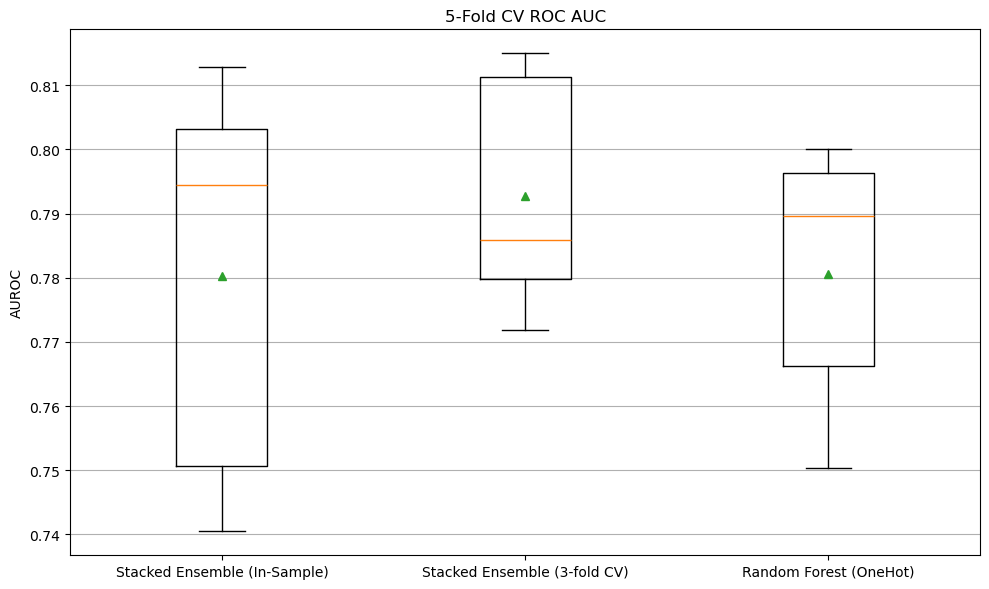

In [4]:
#===SOLUTION===

# Create a new stacked ensemble that uses 3-fold CV to generate out-of-sample predictions
# for the level 0 learners.
ensemble_cv = StackingClassifier(
    estimators=estimators,            
    final_estimator=meta_learner,        
    cv=3,                               
    stack_method='predict_proba',
    passthrough=False
)

# Define models to benchmark
benchmark_models = {
    "Random Forest (OneHot)": rf,
    "Stacked Ensemble (3-fold CV)": ensemble_cv
}

# Use 5-fold stratified CV to evaluate ROC AUC
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2409)
benchmark_results = {}

# Standard cross-validation for regular models
print("\n5-Fold CV ROC AUC Scores for Models:")
for name, model in benchmark_models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")
    benchmark_results[name] = scores
    print(f"{name}: Mean AUC = {np.mean(scores):.3f}, Scores = {scores}")

# Manual cross-validation for in-sample stacked ensemble
cv_scores_in_sample = []
print("\nManual 5-Fold CV for In-Sample Stacked Ensemble:")

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Fit each base estimator on the training data
    fitted_estimators = []
    for name, estimator in estimators:
        fitted_est = clone(estimator)
        fitted_est.fit(X_train, y_train)
        fitted_estimators.append((name, fitted_est))
    
    # Create and fit the in-sample stacker
    fold_stacker = StackingClassifier(
        estimators=fitted_estimators,
        final_estimator=clone(meta_learner),
        cv="prefit",
        stack_method='predict_proba'
    )
    fold_stacker.fit(X_train, y_train)
    
    # Evaluate on test fold
    y_pred_proba = fold_stacker.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, y_pred_proba)
    cv_scores_in_sample.append(score)

# Create a new ordered dictionary with the models in the specified order to align with R solution
new_benchmark_results = {}
new_benchmark_results["Stacked Ensemble (In-Sample)"] = np.array(cv_scores_in_sample)
new_benchmark_results["Stacked Ensemble (3-fold CV)"] = benchmark_results["Stacked Ensemble (3-fold CV)"]
new_benchmark_results["Random Forest (OneHot)"] = benchmark_results["Random Forest (OneHot)"]

# Update the benchmark_results with the new order
benchmark_results = new_benchmark_results

print(f"In-Sample Stacked Ensemble: Mean AUC = {np.mean(cv_scores_in_sample):.3f}, Scores = {cv_scores_in_sample}")

results_df = pd.DataFrame({
    "Model": np.repeat(list(benchmark_results.keys()), 5),
    "AUC": np.concatenate(list(benchmark_results.values()))
})

plt.figure(figsize=(10, 6))
plt.boxplot([results_df[results_df['Model'] == model]['AUC'] for model in benchmark_results.keys()], 
            labels=benchmark_results.keys(), showmeans=True)
plt.title("5-Fold CV ROC AUC")
plt.grid(axis='y')
plt.ylabel("AUROC")
plt.tight_layout()
plt.show()


## 2.3 Add the Original Features of the Task

So far we have dropped the original features of the task. Create another stacked ensemble where you additionally keep the original features of the task. Similarly to before, cross-validate the level 0 predictions.

Proceed to benchmark the cross-validated stacked ensemble with features passed through against the cross-validated stacked ensemble, stacked ensemble, and the random forest. Use 5-fold CV to evaluate the ROC AUC of the models.


<div style="border-left: 6px solid #f5c518; background-color: #fff3cd; padding: 1em; margin: 1em 0;">
  <strong>⚠️ Warning:</strong><br>
  Our current ensemble candidate expects raw input features, as each model includes its own pre-processing steps. Therefore, if we set <code>passthrough=True</code> in the <code>StackingClassifier</code>, the raw features passed to the meta-model will include a mix of numerical and categorical data. However, the meta-model is not equipped to handle categorical features directly.

  Additionally, attaching pre-processors to the meta-model does not work as expected — scikit-learn throws an error. For more details on this open issue, please refer to the  
  <a href="https://github.com/scikit-learn/scikit-learn/issues/16473" target="_blank">Github discussion</a>.

  While it is theoretically possible to implement a custom stacking classifier from scratch, doing so may introduce compatibility issues with scikit-learn utilities like <code>cross_val_score</code> and others.

  As a result, we are skipping this exercise in the Python solution for now. Please use the R solution for learning.
</div>


## 2.4 Multilayer Stacking Ensemple

Finally, create a multi-layer stacking ensemble by passing the output of the current level 0 into a level 1 that is built similar as level 1. Similarly to before, **keep the original features** of the task and cross-validate the level 0 and level 1 predictions. Then use a logistic regression on the final level 2. Make sure that when you pass the original features of the task to the final level 2 that you do not also pass the cross-validated predictions from level 1.

Proceed to benchmark the this cross-validated multi-layer stacked ensemble with features passed through against the cross-validated stacked ensemble with features passed, the cross-validated stacked ensemble, stacked ensemble, and the random forest. Use 5-fold CV to evaluate the ROC AUC of the models.

<div style="border-left: 6px solid #f5c518; background-color: #fff3cd; padding: 1em; margin: 1em 0;">
  <strong>⚠️ Warning:</strong><br>
  For the same reason as in 2.3, we are skipping this exercise in the Python solution for now. Please use the R solution for learning.
</div>

In [5]:
import shutil
import os

# Check if the directory exists and remove it if it does
if os.path.exists("./outcmaes"):
    shutil.rmtree("./outcmaes")


## Summary

We implemented Greedy Ensemble Selection from scratch. Then we look at how to implement various ways of stacked ensemblings and benchmarked them.